In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.io
import pywt

In [2]:
base_dir = os.path.dirname(os.getcwd())
codes_dir = os.path.join(base_dir, "functions/signal_generation")
if codes_dir not in sys.path:
    sys.path.append(codes_dir)

In [3]:
filenames = ['normal', 'inner_race_7', 'inner_race_14', 'inner_race_21',\
             'ball_7', 'ball_14', 'ball_21', 'outer_race_7', 'outer_race_14', 'outer_race_21']

def create_dataset(n=1024, sensor=0):
    X = []
    y = []
    
    categories = [np.eye(10)[i] for i in range(10)]
    
    for category, target in zip(filenames, categories):
        filename = category + '.mat'
        filename = os.path.join("cwru_10_classes_dataset", filename)
        mat_data = scipy.io.loadmat(filename)
        
        # Extract variable names from the loaded .mat file
        variable_names = [var for var in mat_data if not var.startswith('__')]
        
        data = mat_data[variable_names[sensor]]
        
        num_data = data.shape[0]
        num_signals = num_data // n
    
        # Reshape the data into segments of size n
        split_signals = data[:num_signals * n].reshape(num_signals, n)
        # Append the split signals and target to X and y
        split_signals = norm(split_signals)
        X.append(split_signals)
        y.append(np.tile(target, (num_signals, 1)))  # Repeat target for each signal segment
    
    # Convert X and y to NumPy arrays
    X = np.concatenate(X, axis=0)
    X = np.apply_along_axis(norm, axis=1, arr=X)
    y = np.concatenate(y, axis=0)
    
    print("X shape:", X.shape)
    print("y shape:", y.shape)

    return X, y


def norm(data):
    return (data-data.mean())/(data.max()-data.min())


In [4]:
X, y = create_dataset(n=1024)

X shape: (1305, 1024)
y shape: (1305, 10)


In [5]:
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

In [6]:
df = pd.DataFrame(X.T)

In [7]:
def segregate_fault_severity(df, order=500, idx=0):
    all_max_indices = argrelextrema(df[idx].values, np.greater_equal, order=order)[0]
    peaks_df = pd.DataFrame({
        'index': all_max_indices,
        'value': df.iloc[all_max_indices][idx]
    })
    peaks_df = peaks_df[peaks_df['value'] > 0]
    peaks_df = peaks_df.sort_values(by='value').reset_index(drop=True)
    
    n_segments = 4
    segment_size = len(peaks_df) // n_segments
    segments = []
    for i in range(n_segments):
        segment_start = i * segment_size
        segment_end = (i + 1) * segment_size if i < n_segments - 1 else len(peaks_df)
        segment = peaks_df.iloc[segment_start:segment_end]
        segments.append(segment)
    peaks_dict = peaks_df.to_dict('records')
    max_indices = [segment['index'].iloc[-1] for segment in segments]
    
    plt.figure(figsize=(15, 7))
    plt.plot(df[idx], label='Vibration Data')
    # max_indices = max_indices[1:]
    # Plot the max points and regions
    for idx, max_idx in enumerate(max_indices):
        plt.scatter(max_idx, df[idx][max_idx], c='g', label=f'Max Point {idx+1}' if idx == 0 else "")
        plt.axvline(x=max_idx, color='r', linestyle='--', label=f'max_index {idx+1}' if idx == 0 else "")
        plt.text(max_idx, df[idx].min(), f'', rotation=90, verticalalignment='bottom')
    if len(max_indices) == 4:
        plt.text((max_indices[0] + max_indices[1]) / 2, df[idx].max(), 'Low Severe', horizontalalignment='center', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
        plt.text((max_indices[1] + max_indices[2]) / 2, df[idx].max(), 'Medium Severe', horizontalalignment='center', fontsize=12, bbox=dict(facecolor='orange', alpha=0.5))
        plt.text((max_indices[2] + max_indices[3]) / 2, df[idx].max(), 'High Severe', horizontalalignment='center', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    plt.title('Horizontal Vibration Data with Severity Regions')
    plt.xlabel('Time')
    plt.ylabel('Horizontal Acceleration')
    plt.legend()
    plt.show()
    fig, axes = plt.subplots(n_segments, 1, figsize=(15, 15), sharex=True)
    for i, segment in enumerate(segments):
        axes[i].plot(df[idx], label='Horizontal Vibration Data', alpha=0.5)
        axes[i].scatter(segment['index'], segment['value'], c='g')
        axes[i].set_title(f'Segment {i+1}')
        for max_idx in max_indices:
            if segment['index'].min() <= max_idx <= segment['index'].max():
                axes[i].axvline(x=max_idx, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    return max_indices

In [ ]:
df = pd.DataFrame(X.T)

In [8]:
# idx = 400
# df_col = df[[idx]]
# df_col.columns = [0]

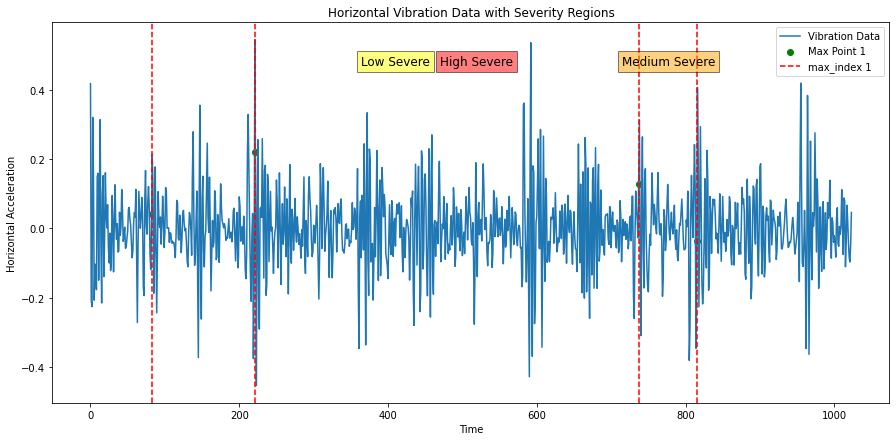

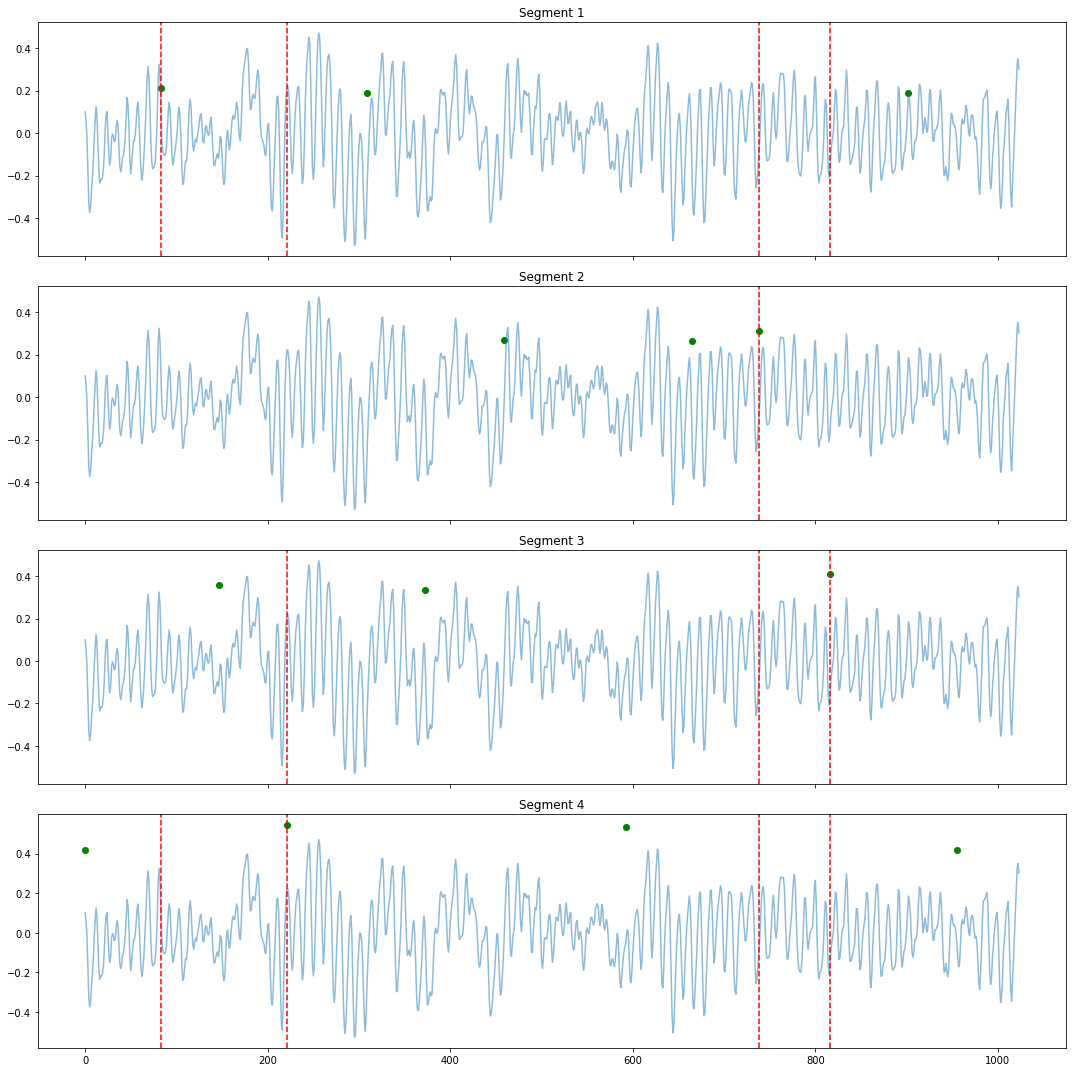

[83, 738, 816, 221]

In [9]:
segregate_fault_severity(df=df, order=50, idx=300)

## n=1024
|    | Category      |   Count |   Start Index |   End Index |
|---:|:--------------|--------:|--------------:|------------:|
|  0 | normal        |     238 |             0 |         237 |
|  1 | inner_race_7  |     118 |           238 |         355 |
|  2 | inner_race_14 |     118 |           356 |         473 |
|  3 | inner_race_21 |     119 |           474 |         592 |
|  4 | ball_7        |     119 |           593 |         711 |
|  5 | ball_14       |     118 |           712 |         829 |
|  6 | ball_21       |     119 |           830 |         948 |
|  7 | outer_race_7  |     119 |           949 |        1067 |
|  8 | outer_race_14 |     118 |          1068 |        1185 |
|  9 | outer_race_21 |     119 |          1186 |        1304 |

## n=4096
|    | Category      |   Count |   Start Index |   End Index |
|---:|:--------------|--------:|--------------:|------------:|
|  0 | normal        |      59 |             0 |          58 |
|  1 | inner_race_7  |      29 |            59 |          87 |
|  2 | inner_race_14 |      29 |            88 |         116 |
|  3 | inner_race_21 |      29 |           117 |         145 |
|  4 | ball_7        |      29 |           146 |         174 |
|  5 | ball_14       |      29 |           175 |         203 |
|  6 | ball_21       |      29 |           204 |         232 |
|  7 | outer_race_7  |      29 |           233 |         261 |
|  8 | outer_race_14 |      29 |           262 |         290 |
|  9 | outer_race_21 |      29 |           291 |         319 |

# Classification

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from multiprocessing import Pool

In [6]:
# np.random.seed(42)
def train_val_test_split(X, y, val_test_size=0.1):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Use the shuffled indices to shuffle data and labels
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    # Split the shuffled data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=2*val_test_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate model on training data
    loss_train, acc_train = model.evaluate(X_train, y_train, verbose=0)
    
    print('The accuracy of the model for training data is:', acc_train * 100)
    print('The Loss of the model for training data is:', loss_train)
    
    # Evaluate model on validation data
    loss_val, acc_val = model.evaluate(X_val, y_val, verbose=0)
    
    print('The accuracy of the model for validation data is:', acc_val * 100)
    print('The Loss of the model for validation data is:', loss_val)

    # Evaluation
    loss_test, acc_test = model.evaluate(X_test, y_test, verbose=0)
    
    print('The accuracy of the model for testing data is:', acc_test * 100)
    print('The Loss of the model for testing data is:', loss_test)

In [8]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(16,4))
    
    # Plotting loss vs epoch
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    
    # Plotting accuracy vs epoch
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, X_test, y_test):
    
    y_pred = model(X_test)
    y_pred_ = np.argmax(y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_test_, y_pred_)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

## DWT

In [45]:
X_image_list = []
for x in X:
    data = x.reshape(32,32)
    cA, (cH, cV, cD) = pywt.dwt2(data, 'haar')
    image = np.stack([cA, cH, cV, cD], axis=2)
    image = norm(image)
    X_image_list.append(image)
X_image = np.array(X_image_list)
print(f"X_image shape: {X_image.shape}")

X_image shape: (1305, 16, 16, 4)


In [46]:
skip_indices = [119+i for i in range(119)]  # Indices of samples to skip
mask = np.ones(X_image.shape[0], dtype=bool)
mask[skip_indices] = False

# Apply the mask to the data
X_image = X_image[mask]
y_image = y_image[mask]
print(f"X_image: {X_image.shape}")
print(f"y_image: {y_image.shape}")

X_image: (1186, 16, 16, 4)
y_image: (1186,)


In [47]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_image, y)

In [110]:
def classifier_model_6(input_shape, n_classes=4):
    input = Input(shape=input_shape)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), kernel_initializer= HeNormal(), activation='tanh', padding='same')(input)
    x = Dropout(rate=0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), kernel_initializer= HeNormal(), activation='tanh', padding='same')(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), kernel_initializer= HeNormal(), activation='tanh', padding='same')(x)
    x = Dropout(rate=0.2)(x)
    
    x = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), kernel_initializer= HeNormal(), activation='tanh', padding='same')(x)
    x = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Flatten()(x)
    
    x = Dense(units=32, kernel_initializer= HeNormal(), activation='tanh')(x)
    x = Dropout(rate=0.4)(x)
    
    x = Dense(units=16, kernel_initializer= HeNormal(), activation='tanh')(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(units=16, kernel_initializer= HeNormal(), activation='tanh')(x)
    
    output = Dense(units=n_classes, kernel_initializer= HeNormal(), activation='softmax')(x)

    optimizer = Adam(learning_rate=0.00004,beta_1=0.8)

    model = Model(inputs=input,outputs=output)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [111]:
model = classifier_model_6(X_train.shape[1:], n_classes=10)

In [112]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 16, 16, 4)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 64)        2368      
_________________________________________________________________
dropout_35 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
dropout_36 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
dropout_37 (Dropout)         (None, 16, 16, 64)        0   

In [113]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=450)

Epoch 1/450
30/30 [==============================] - 1s 12ms/step - loss: 2.4376 - accuracy: 0.1173 - val_loss: 2.3483 - val_accuracy: 0.1176
Epoch 2/450
30/30 [==============================] - 0s 6ms/step - loss: 2.4476 - accuracy: 0.1142 - val_loss: 2.3471 - val_accuracy: 0.1092
Epoch 3/450
30/30 [==============================] - 0s 7ms/step - loss: 2.4048 - accuracy: 0.1206 - val_loss: 2.3420 - val_accuracy: 0.1008
Epoch 4/450
30/30 [==============================] - 0s 7ms/step - loss: 2.4149 - accuracy: 0.1325 - val_loss: 2.3451 - val_accuracy: 0.1092
Epoch 5/450
30/30 [==============================] - 0s 7ms/step - loss: 2.4237 - accuracy: 0.1203 - val_loss: 2.3440 - val_accuracy: 0.1008
Epoch 6/450
30/30 [==============================] - 0s 6ms/step - loss: 2.4517 - accuracy: 0.1195 - val_loss: 2.3465 - val_accuracy: 0.0924
Epoch 7/450
30/30 [==============================] - 0s 6ms/step - loss: 2.3704 - accuracy: 0.1327 - val_loss: 2.3416 - val_accuracy: 0.0924
Epoch 8/450


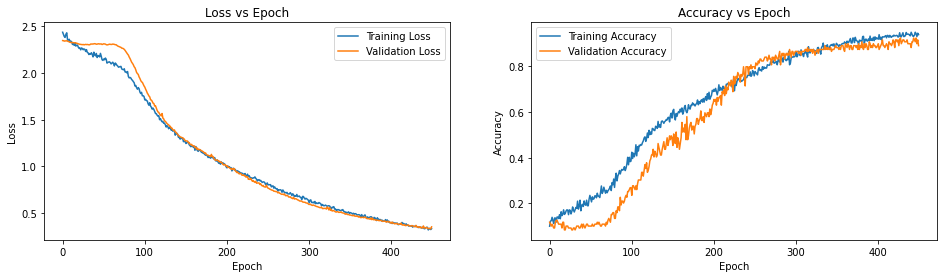

In [114]:
plot_loss_accuracy(history)

In [115]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

The accuracy of the model for training data is: 99.2616057395935
The Loss of the model for training data is: 0.16130225360393524
The accuracy of the model for validation data is: 89.07563090324402
The Loss of the model for validation data is: 0.35143977403640747
The accuracy of the model for testing data is: 90.75630307197571
The Loss of the model for testing data is: 0.3358406126499176


In [117]:
# model.save('DWT_classification_model_10_classes.h5')

In [118]:
from sklearn.metrics import confusion_matrix

In [119]:
y_pred = model(X_test)

In [120]:
y_pred_ = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [121]:
conf_matrix = confusion_matrix(y_test_, y_pred_)

In [122]:
conf_matrix

array([[24,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  7,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 14,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 17,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0,  7]])

<Axes: >

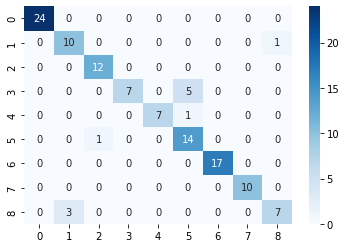

In [123]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

In [25]:
model = classifier_model_4(X_train.shape[1:], n_classes=10)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 6)       156       
_________________________________________________________________
average_pooling2d_5 (Average (None, 256, 256, 6)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256, 256, 6)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 8)       1208      
_________________________________________________________________
average_pooling2d_6 (Average (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 128, 8)       0   

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
33/33 [==============================] - 3s 74ms/step - loss: 2.1031 - accuracy: 0.2465 - val_loss: 1.2828 - val_accuracy: 0.4923
Epoch 2/30
33/33 [==============================] - 2s 67ms/step - loss: 1.3175 - accuracy: 0.4776 - val_loss: 0.9634 - val_accuracy: 0.5846
Epoch 3/30
33/33 [==============================] - 2s 73ms/step - loss: 0.9855 - accuracy: 0.6390 - val_loss: 0.9127 - val_accuracy: 0.5923
Epoch 4/30
33/33 [==============================] - 3s 85ms/step - loss: 0.9312 - accuracy: 0.6375 - val_loss: 0.8473 - val_accuracy: 0.6462
Epoch 5/30
33/33 [==============================] - 2s 64ms/step - loss: 0.9067 - accuracy: 0.6337 - val_loss: 0.7636 - val_accuracy: 0.7231
Epoch 6/30
33/33 [==============================] - 2s 64ms/step - loss: 0.8739 - accuracy: 0.6323 - val_loss: 0.7303 - val_accuracy: 0.7077
Epoch 7/30
33/33 [==============================] - 2s 64ms/step - loss: 0.8262 - accuracy: 0.6483 - val_loss: 0.6799 - val_accuracy: 0.7231
Epoch 8/30
33

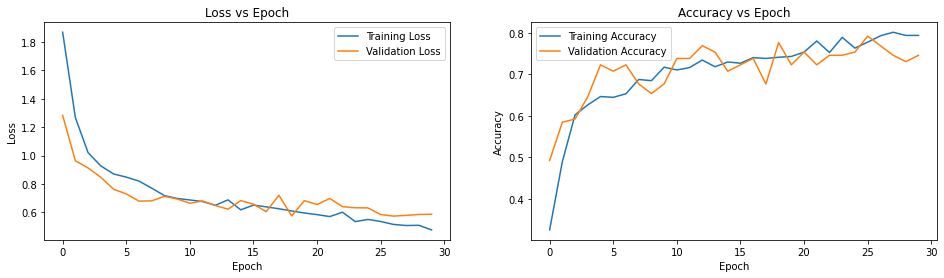

In [28]:
plot_loss_accuracy(history)

In [29]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

The accuracy of the model for training data is: 84.29118990898132
The Loss of the model for training data is: 0.3966049551963806
The accuracy of the model for validation data is: 74.61538314819336
The Loss of the model for validation data is: 0.5876754522323608
The accuracy of the model for testing data is: 75.57252049446106
The Loss of the model for testing data is: 0.5390244126319885


<Axes: >

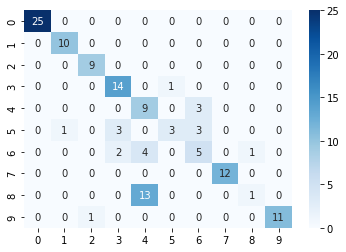

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = model(X_test)
y_pred_ = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_, y_pred_)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

In [14]:
# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.

# Reference:

- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function

import numpy as np
import warnings


from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions




def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.

    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50(input_shape=None, classes=10):

    img_input = Input(shape=input_shape)
    
    bn_axis = 3

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    x = Flatten()(x)
    
    x = Dense(classes, activation='softmax', name='fc10')(x)
    
    # Create model.
    model = Model(img_input, x, name='resnet50')

    optimizer = Adam(learning_rate=0.001,beta_1=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [24]:
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(32,32,1),
    pooling=None,
    classes=10,
    classifier_activation='softmax'
)

In [27]:
model = ResNet50(input_shape=X_train.shape[1:], classes=10)

In [28]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[32,1024,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node resnet50/res4c_branch2c/Conv2D (defined at <ipython-input-29-21adc032c62c>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_25172]

Function call stack:
train_function


In [13]:
import tensorflow as tf


class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.downsample = tf.keras.Sequential()
        self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride))
        self.downsample.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block

In [14]:
NUM_CLASSES = 10


class ResNetTypeI(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeI, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


class ResNetTypeII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeII, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                            blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                            blocks=layer_params[1],
                                            stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                            blocks=layer_params[2],
                                            stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                            blocks=layer_params[3],
                                            stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


def resnet_18():
    return ResNetTypeI(layer_params=[2, 2, 2, 2])


def resnet_34():
    return ResNetTypeI(layer_params=[3, 4, 6, 3])


def resnet_50():
    return ResNetTypeII(layer_params=[3, 4, 6, 3])


def resnet_101():
    return ResNetTypeII(layer_params=[3, 4, 23, 3])


def resnet_152():
    return ResNetTypeII(layer_params=[3, 8, 36, 3])

In [39]:
model = resnet_50()
model.build(input_shape=(None, 16, 16, 4))
optimizer = Adam(learning_rate=0.001,beta_1=0.999)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "res_net_type_ii"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_132 (Conv2D)          multiple                  12608     
_________________________________________________________________
batch_normalization_132 (Bat multiple                  256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
sequential_35 (Sequential)   (None, 4, 4, 256)         353664    
_________________________________________________________________
sequential_39 (Sequential)   (None, 2, 2, 512)         2024448   
_________________________________________________________________
sequential_44 (Sequential)   (None, 1, 1, 1024)        12397568  
_________________________________________________________________
sequential_51 (Sequential)   (None, 1, 1, 2048)    

In [44]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
33/33 [==============================] - 2s 51ms/step - loss: 0.5412 - accuracy: 0.8285 - val_loss: 1.4009 - val_accuracy: 0.5692
Epoch 2/30
33/33 [==============================] - 2s 51ms/step - loss: 0.4765 - accuracy: 0.8420 - val_loss: 1.6778 - val_accuracy: 0.5462
Epoch 3/30
33/33 [==============================] - 2s 50ms/step - loss: 0.5549 - accuracy: 0.8305 - val_loss: 1.4936 - val_accuracy: 0.5462
Epoch 4/30
33/33 [==============================] - 2s 50ms/step - loss: 0.4194 - accuracy: 0.8621 - val_loss: 2.2771 - val_accuracy: 0.5846
Epoch 5/30
33/33 [==============================] - 2s 49ms/step - loss: 0.5196 - accuracy: 0.8544 - val_loss: 2.3657 - val_accuracy: 0.5769
Epoch 6/30
33/33 [==============================] - 2s 49ms/step - loss: 0.4866 - accuracy: 0.8410 - val_loss: 2.0540 - val_accuracy: 0.5615
Epoch 7/30
33/33 [==============================] - 2s 49ms/step - loss: 0.4573 - accuracy: 0.8688 - val_loss: 2.1316 - val_accuracy: 0.5769
Epoch 8/30
33

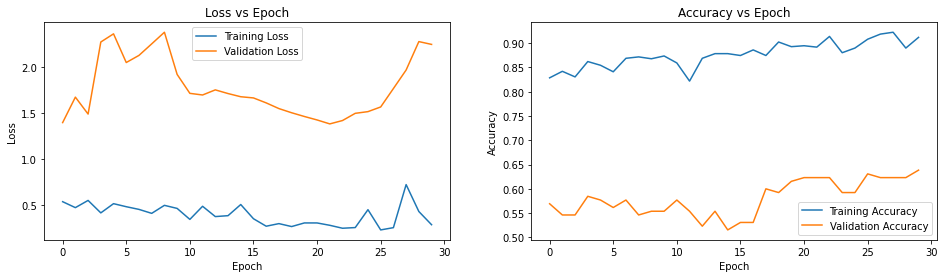

In [45]:
plot_loss_accuracy(history)

In [46]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

The accuracy of the model for training data is: 93.96551847457886
The Loss of the model for training data is: 0.24917258322238922
The accuracy of the model for validation data is: 63.846153020858765
The Loss of the model for validation data is: 2.2510294914245605
The accuracy of the model for testing data is: 54.19847369194031
The Loss of the model for testing data is: 2.7300572395324707


In [10]:
def wigner_ville(signal):
    n = len(signal)
    wvd = np.zeros((n, n), dtype=np.complex128)

    for t1 in range(n):
        for t2 in range(n):
            tau = t2 - t1
            if 0 <= tau < n:
                wvd[t1, t2] = signal[t1] * np.conj(signal[t2]) if t1 != t2 else 0

    return np.fft.fftshift(np.fft.fft2(wvd))
    

In [ ]:
def parallel_map_with_progress(func, iterable):
    total = len(iterable)
    with Pool() as pool:
        results = []
        for i, result in enumerate(pool.imap_unordered(func, iterable)):
            real_part = np.real(result)
            imag_part = np.imag(result)
            res = np.stack((real_part, imag_part), axis=-1)
            res = norm(res)
            results.append(res)
            progress = (i + 1) / total * 100
            print(f'Progress: {progress:.2f}% ({i+1}/{total})', end='\r', flush=True)
        print('\n') 
    images = np.array(results)
    images = norm(images)
    return images

# GMM images creation using parallelization
X_image = parallel_map_with_progress(wigner_ville, X)

Progress: 100.00% (1305/1305)



In [ ]:
# skip_indices = [30+i for i in range(30)]  # Indices of samples to skip
skip_indices = [119+i for i in range(119)]  # Indices of samples to skip
mask = np.ones(X_image.shape[0], dtype=bool)
mask[skip_indices] = False

# Apply the mask to the data
X_image = X_image[mask]
y = y[mask]
print(f"X_image: {X_image.shape}")
print(f"y_image: {y.shape}")

In [ ]:
from tqdm import tqdm
X_image_ = []
for x in tqdm(X_image):
    x_l2_norm = np.log(1+np.sqrt(np.sum(np.square(x), axis=-1, keepdims=True)))
    X_image_.append(x_l2_norm)

X_image_ = np.array(X_image_)               
    

In [ ]:
X_image_.shape

In [13]:
# with tf.device('/GPU:0'):
#     X_image = tf.convert_to_tensor(X_image)
#     y = tf.convert_to_tensor(y)

In [20]:
# X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_image, y)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X_image_, y)

### ResNet

In [29]:
# -*- coding: utf-8 -*-
'''ResNet model for Keras.

# Reference:

- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function

import numpy as np
import warnings


from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.initializers import HeNormal, GlorotNormal




def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.
    """
    # filters1, filters2, filters3 = filters
    filters1, filters3 = filters

    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), kernel_initializer=HeNormal(), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    # x = Conv2D(filters2, kernel_size,
    #            padding='same', name=conv_name_base + '2b')(x)
    # x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    # x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), kernel_initializer=HeNormal(), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    # Returns
        Output tensor for the block.

    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    # filters1, filters2, filters3 = filters
    filters1, filters3 = filters
    
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), kernel_initializer=HeNormal(), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    # x = Conv2D(filters2, kernel_size, padding='same',
    #            name=conv_name_base + '2b')(x)
    # x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    # x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), kernel_initializer=HeNormal(), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet_custom(input_shape=None, classes=10):

    img_input = Input(shape=input_shape)
    
    bn_axis = 3

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=HeNormal(), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [32, 32], stage=2, block='a', strides=(1, 1))
    # x = identity_block(x, 3, [64, 256], stage=2, block='b')
    # x = identity_block(x, 3, [64, 256], stage=2, block='c')

    # x = conv_block(x, 3, [128, 512], stage=3, block='a')
    # x = identity_block(x, 3, [128, 512], stage=3, block='b')
    # x = identity_block(x, 3, [128, 512], stage=3, block='c')
    # x = identity_block(x, 3, [128, 512], stage=3, block='d')

    x = conv_block(x, 3, [64, 64], stage=4, block='a')
    x = identity_block(x, 3, [64, 64], stage=4, block='b')
    # x = identity_block(x, 3, [256, 1024], stage=4, block='c')
    # x = identity_block(x, 3, [256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [32, 32], stage=4, block='f')

    x = conv_block(x, 3, [128, 128], stage=5, block='a')
    # x = identity_block(x, 3, [512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    x = Flatten()(x)
    
    x = Dense(classes, activation='softmax', kernel_initializer=HeNormal(), name='fc10')(x)
    
    # Create model.
    model = Model(img_input, x, name='resnet_custom')

    # optimizer = Adam(learning_rate=0.001,beta_1=0.999)
    optimizer = Adam(learning_rate=0.0001,beta_1=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [30]:
model = ResNet_custom(input_shape=X_train.shape[1:], classes=10)

In [31]:
model.summary()

Model: "resnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 1030, 1030, 1 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
______________________________________________________________________________________

In [46]:
optimizer = Adam(learning_rate=0.000001,beta_1=0.5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
30/30 [==============================] - 13s 397ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1120 - val_accuracy: 0.9916
Epoch 2/10
30/30 [==============================] - 11s 379ms/step - loss: 0.0018 - accuracy: 0.9987 - val_loss: 0.1121 - val_accuracy: 0.9916
Epoch 3/10
30/30 [==============================] - 11s 379ms/step - loss: 7.5761e-04 - accuracy: 1.0000 - val_loss: 0.1122 - val_accuracy: 0.9916
Epoch 4/10
30/30 [==============================] - 11s 381ms/step - loss: 9.1392e-04 - accuracy: 1.0000 - val_loss: 0.1125 - val_accuracy: 0.9916
Epoch 5/10
30/30 [==============================] - 11s 382ms/step - loss: 6.8813e-04 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 0.9916
Epoch 6/10
30/30 [==============================] - 12s 388ms/step - loss: 4.3607e-04 - accuracy: 1.0000 - val_loss: 0.1129 - val_accuracy: 0.9916
Epoch 7/10
30/30 [==============================] - 14s 454ms/step - loss: 7.7516e-04 - accuracy: 1.0000 - val_loss: 0.1135 - 

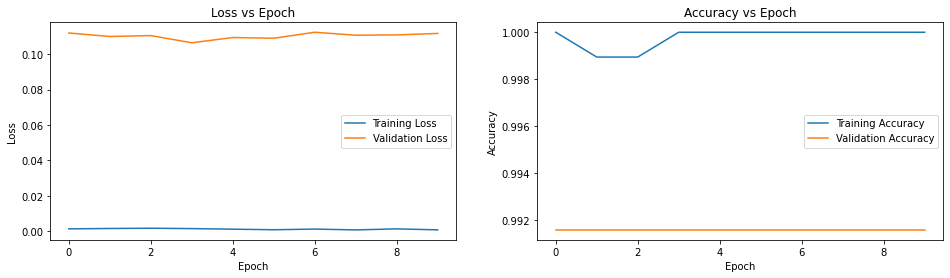

In [44]:
plot_loss_accuracy(history)

In [45]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

The accuracy of the model for training data is: 100.0
The Loss of the model for training data is: 0.0007292311056517065
The accuracy of the model for validation data is: 99.15966391563416
The Loss of the model for validation data is: 0.11177395284175873
The accuracy of the model for testing data is: 98.31932783126831
The Loss of the model for testing data is: 0.11720232665538788


In [23]:
# model.save("DWT_classifier_10_classes.h5")

In [29]:
# model_load = tf.keras.models.load_model('DWT_classifier_10_classes.h5')

In [30]:
# evaluate_model(model_load, X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

    
y_pred = model_load(X_test)
y_pred_ = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_, y_pred_)
    
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

### LeNet

In [20]:
def classifier_model_8(input_shape, n_classes=4):
    input = Input(shape=input_shape)
    x = Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), activation='tanh', padding='same')(input)

    x = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), activation='tanh', padding='same')(x)
    x = Dropout(rate=0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), activation='tanh', padding='same')(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), activation='tanh', padding='same')(x)
    x = Dropout(rate=0.2)(x)
    
    x = Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='tanh', padding='same')(x)
    x = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)

    x = Dense(units=32, activation='tanh')(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(units=16, activation='tanh')(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(units=8, activation='tanh')(x)
    x = Dropout(rate=0.2)(x)
    
    output = Dense(units=n_classes, activation='softmax')(x)

    optimizer = Adam(learning_rate=0.0004, beta_1=0.9)

    model = Model(inputs=input,outputs=output)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [21]:
model = classifier_model_8(X_train.shape[1:], n_classes=10)

2024-07-30 18:29:20.264889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-07-30 18:29:20.266030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9797 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-07-30 18:29:20.266928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9797 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-07-30 18:29:20.267814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9797 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4096, 4096, 2)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2048, 2048, 32) │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1024, 1024, 64) │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024, 1024, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 512, 512, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512, 512, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 16)   │        25,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 128, 128, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     8,388,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,877,698 (33.87 MB)

 Trainable params: 8,877,698 (33.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15)

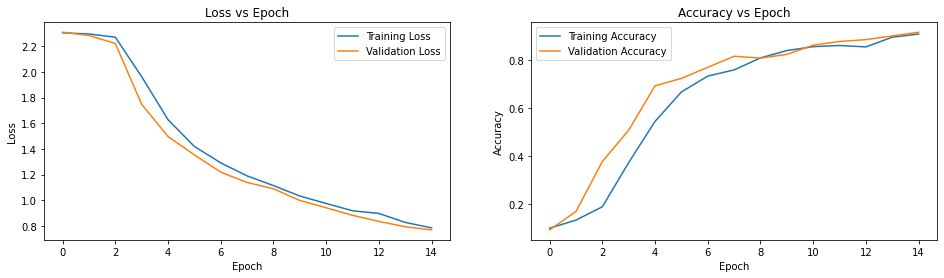

In [22]:
plot_loss_accuracy(history)

In [23]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)

The accuracy of the model for training data is: 99.52107071876526
The Loss of the model for training data is: 0.5520176291465759
The accuracy of the model for validation data is: 91.5384590625763
The Loss of the model for validation data is: 0.7675415277481079
The accuracy of the model for testing data is: 96.1832046508789
The Loss of the model for testing data is: 0.6552577018737793


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
    
y_pred = model(X_test)
y_pred_ = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_, y_pred_)
    
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Signal Generation

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape, ReLU, Lambda
from tensorflow.keras import backend as K
from tensorflow import keras
from multiprocessing import Pool

In [5]:
def norm_11(data):
    return (data-data.min())/(data.max()-data.min())

In [7]:
# DWT
X_image_list = []
for x in X:
    data = x.reshape(32,32)
    cA, (cH, cV, cD) = pywt.dwt2(data, 'haar')
    image = np.stack([cA, cH, cV, cD], axis=2)
    image = norm_11(image)
    X_image_list.append(image)
X_image = np.array(X_image_list)
y_image = np.argmax(y,axis=-1)

print(f"X_image: {X_image.shape}")
print(f"y_image: {y_image.shape}")

X_image: (1305, 16, 16, 4)
y_image: (1305,)


In [8]:
skip_indices = [119+i for i in range(119)]  # Indices of samples to skip
mask = np.ones(X_image.shape[0], dtype=bool)
mask[skip_indices] = False

# Apply the mask to the data
X_image = X_image[mask]
y_image = y_image[mask]
print(f"X_image: {X_image.shape}")
print(f"y_image: {y_image.shape}")

X_image: (1186, 16, 16, 4)
y_image: (1186,)


In [1]:
skip_indices = [119+i for i in range(119)]
print(skip_indices)

[119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237]


## Diffusion Model

### utils

In [6]:
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset


def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def get_data(args, X, y):
    transform = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        # torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
    ])
    
    dataset = CustomDataset(X, y, transform=transform)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

### modules

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class UNet_conditional(nn.Module):
    def __init__(self, c_in=4, c_out=4, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 8)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 4)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 4)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 8)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 16)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)
            # t += self.label_emb(y).unsqueeze(1)  # gpt correction suggestion

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

### ddpm_conditional

In [8]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
# from utils import *
# from modules import UNet_conditional, EMA
# import logging
# from torch.utils.tensorboard import SummaryWriter

# logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        # logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 4, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        # x = (x * 255).type(torch.uint8)
        return x

## Train

def train(args, X, y):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args, X, y)
    model = UNet_conditional(num_classes=args.num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    # logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    # List to store generated images
    all_sampled_images = []
    
    for epoch in range(args.epochs):
        # logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device).float()
            labels = labels.to(device).long()
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

            # pbar.set_postfix(MSE=loss.item())
            # logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        if epoch % 10 == 0:
            labels = torch.arange(4).long().to(device)
            sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            # plot_images(sampled_images)
            # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
            # save_images(ema_sampled_images, os.path.join("results", args.run_name, f"{epoch}_ema.jpg"))
            torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))
            torch.save(ema_model.state_dict(), os.path.join("models", args.run_name, f"ema_ckpt.pt"))
            torch.save(optimizer.state_dict(), os.path.join("models", args.run_name, f"optim.pt"))

            # Save sampled images to list
            all_sampled_images.append(sampled_images.cpu().numpy())

    # Convert list of sampled images to NumPy array
    all_sampled_images = np.array(all_sampled_images)

    return all_sampled_images


def launch(X, y):
    import argparse
    parser = argparse.ArgumentParser()
    args = parser.parse_args(args=[])
    args.run_name = "DDPM_conditional_10_classes"
    args.epochs = 1000
    args.batch_size = 4
    args.image_size = 16
    args.num_classes = 10
    args.device = "cuda"
    args.lr = 3e-4
    return train(args, X, y)

In [ ]:
generated_images = launch(X_image, y_image)

In [ ]:
np.save("TRAINING_GENERATED_IMAGES_DIFFUSION_10_CLASSES.npy", generated_images)

In [1]:
import numpy as np
img = np.load("TRAINING_GENERATED_IMAGES_DIFFUSION_10_CLASSES.npy")

In [2]:
img.shape

(200, 4, 4, 16, 16)

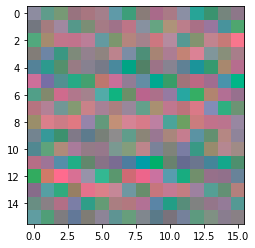

In [10]:
import matplotlib.pyplot as plt
p_img = img[][0].transpose(1, 2, 0)
image = p_img[:,:,1:]
plt.imshow((image - image.min())/(image.max()-image.min()))

In [ ]:
sampled_images_during_training = generated_images.transpose(0, 1, 3, 4, 2)

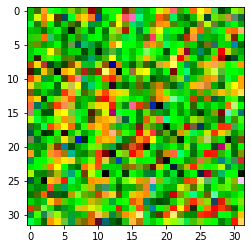

In [23]:
plt.imshow(sampled_images_during_training[26, 0, :, :, 1:])
plt.show()

### Load Trained Model

In [10]:
def generate_diffusion_images(n = 10, ckpt_path=None, output_file='GENERATED__DIFFUSION_IMAGES.npy'):
    device = torch.device('cuda') #"cpu"
    model = UNet_conditional(num_classes=10).to(device)

    assert ckpt_path is not None, "Provide model path"
    
    ckpt = torch.load(ckpt_path)
    
    model.load_state_dict(ckpt)
    diffusion = Diffusion(img_size=16, device=device)
    
    assert n % 10 == 0, "n must be a multiple of 10"
    base_sequence = torch.arange(10).to(device)
    yy = base_sequence.repeat(n // 10).long().to(device)
    
    x = diffusion.sample(model, n, yy, cfg_scale=0)
    
    
    output_img = x.permute(0, 2, 3, 1).cpu().numpy()
    
    np.save(output_file, output_img)


In [29]:
ckpt_path = "models/DDPM_conditional_10_classes/ckpt.pt"
output_file = "GENERATED__DIFFUSION_IMAGES_10_CLASSES.npy"
generate_diffusion_images(n = 100, ckpt_path=ckpt_path, output_file=output_file)

999it [00:28, 35.14it/s]


In [9]:
import numpy as np
generated_images = np.load("GENERATED__DIFFUSION_IMAGES_10_CLASSES.npy") 
generated_images.shape

(100, 16, 16, 4)

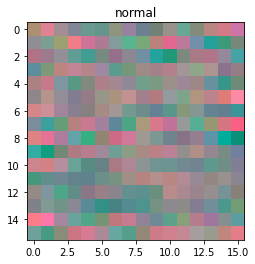

In [10]:
from utils import plot_generated_image
plot_generated_image(generated_images, idx=90, filenames=filenames)

In [11]:
from tensorflow.keras.models import load_model
classifier_model = load_model('DWT_classification_model_10_classes.h5')

In [12]:
from utils import generate_signal_from_image, plot_signal_all_class
rec_signal, pred = generate_signal_from_image(generated_images, classifier_model=classifier_model)

In [13]:
reconstructed_signal = np.array(rec_signal)

In [15]:
# np.save("CWRU_10_CLASSES_DIFFUSION_GENERATED_SIGNALS.npy", reconstructed_signal)

In [128]:
def wigner_ville(signal):
    n = len(signal)
    wvd = np.zeros((n, n), dtype=np.complex128)

    for t1 in range(n):
        for t2 in range(n):
            tau = t2 - t1
            if 0 <= tau < n:
                wvd[t1, t2] = signal[t1] * np.conj(signal[t2]) if t1 != t2 else 0

    return np.fft.fftshift(np.fft.fft2(wvd))


In [129]:
def parallel_map_with_progress(func, iterable):
    total = len(iterable)
    with Pool() as pool:
        results = []
        for i, result in enumerate(pool.imap_unordered(func, iterable)):
            real_part = np.real(result)
            imag_part = np.imag(result)
            res = np.stack((real_part, imag_part), axis=-1)
            res = norm(res)
            results.append(res)
            progress = (i + 1) / total * 100
            print(f'Progress: {progress:.2f}% ({i+1}/{total})', end='\r', flush=True)
        print('\n') 
    images = np.array(results)
    images = norm(images)
    return images

In [18]:
# ### For Wigner Ville Distribution
# signals = parallel_map_with_progress(wigner_ville, rec_signal)
# preds = classifier_model(signals)
# preds
# predict = []
# for i in range(len(preds)):
#     predict.append(preds[i][i])
# predict = np.array(predict)

In [ ]:
no_of_rec_signals = len(rec_signal)
for idx in range(0,no_of_rec_signals,10):
    # plot_signal_all_class(idx = 0, rec_signal_list=rec_signal, pred_string_list=["","","","","","","","","",""], filenames=filenames)
    plot_signal_all_class(idx = 0, rec_signal_list=rec_signal, pred_string_list=pred, filenames=filenames)